# Workflow para análisis de los principales parámetros e Indices de imágenes satelitales en Python

### Seteo del directorio de trabajo

In [1]:
import os
os.chdir('C:/Proyecto_Final_Imagenes_Satelitales/')

### Seteo de la API de Sentinel la cual se utilizara para descargar datos de sentinel2 directamente con un script de Python

In [2]:
import json
from sentinelsat import SentinelAPI

creds = {}
with open('C:/water_quality/credentials.json') as temp:
    creds = json.load(temp)
    
user = creds['uid']
passw = creds['pass']

api = SentinelAPI(user, passw, 'https://scihub.copernicus.eu/dhus')


### Lectura de los archivos shape files para crear los footprints de consulta para el sentinel API para descarga de las imágenes:

In [3]:
import geopandas as gpd
import folium
from shapely.geometry import MultiPolygon, Polygon

#defining footprint for Lago Puelo
Lago_Puelo = gpd.read_file('C:/Proyecto_Final_Imagenes_Satelitales/layers/POLYGON.shp')
Lago_Puelo_footprint = Lago_Puelo['geometry']

### Query del Sentinel con los datos que utilizan los footprints obtenidos con geojson:

In [4]:
products_Lago_Puelo = api.query(
            Lago_Puelo_footprint[0],
            date = ('20201106', '20201109'),
            platformname = 'Sentinel-2',
            processinglevel = 'Level-2A',
            cloudcoverpercentage = (0,40)
)

### Analyzing the query results selectively downloading the required data

In [5]:
from pyproj import Proj, CRS,transform

#converting into dataframes to choose the product

Lago_Puelo_df = api.to_geodataframe(products_Lago_Puelo)
Lago_Puelo_df = Lago_Puelo_df.sort_values(['cloudcoverpercentage'], ascending=True)

Lago_Puelo_df


target3 = Lago_Puelo_df['uuid'][0]

C:\Anaconda3\envs\geo_py38\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
#downloading the images
#api.download(target3)

### Después de descomprimir las carpetas, leer los archivos de las bandas usando el paquete "rasterio", para eventualmente guardar diferentes combinaciones de bandas en formato GeoTIFF

### Representacion de las bandas RGB:

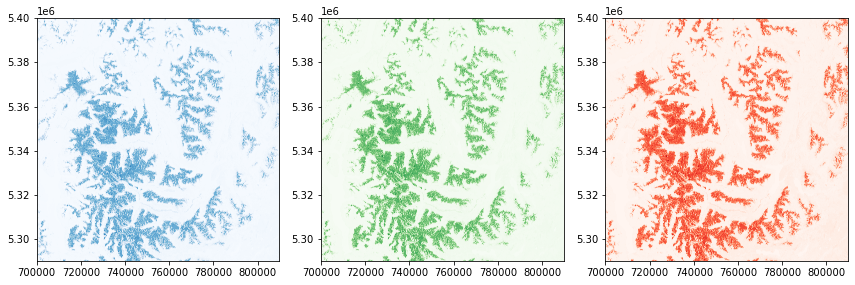

In [7]:
#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
%matplotlib inline

#import bands as separate 1 band raster
band2 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B02_10m.jp2', driver='JP2OpenJPEG') #blue
band3 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B03_10m.jp2', driver='JP2OpenJPEG') #green
band4 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B04_10m.jp2', driver='JP2OpenJPEG') #red
band8 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B08_10m.jp2', driver='JP2OpenJPEG') #nir


#multiple band representation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot.show(band2, ax=ax1, cmap='Blues')
plot.show(band3, ax=ax2, cmap='Greens')
plot.show(band4, ax=ax3, cmap='Reds')
fig.tight_layout()

## Principales Indices de imágenes satelitales 

Para todos los indices calculados, los valores más brillantes representan la característica del índice mientras que otros rasgos aparecen con valores más oscuros.

### 1) True color composite (Based on bands 4,3,2)

Los sensores transportados por los satélites pueden tomar imágenes de la Tierra en diferentes regiones del espectro electromagnético. Cada región del espectro se denomina banda. Sentinel-2 tiene 13 bandas. El compuesto de "True Color" (bandas 2,3 y 4) utiliza bandas de luz visible roja, verde y azul en los correspondientes canales de color rojo, verde y azul, lo que da como resultado un producto de color natural, que es una buena representación de la Tierra como la verían los humanos de forma natural.

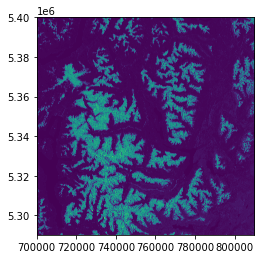

<AxesSubplot:>

In [8]:
#export true color image
trueColor = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/TrueColor_LagoPuelo.tiff','w',driver='Gtiff',
                         width=band4.width, height=band4.height,
                         count=3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         )
trueColor.write(band2.read(1),3) #blue
trueColor.write(band3.read(1),2) #green
trueColor.write(band4.read(1),1) #red
trueColor.close()

src = rasterio.open(r"C:/Proyecto_Final_Imagenes_Satelitales/TrueColor_LagoPuelo.tiff", count=3)
plot.show(src)

### 2) False color composite (Based on bands 8,4,3)

Un compuesto de color falso utiliza al menos una longitud de onda no visible para representar a la Tierra. El compuesto de color falso que utiliza bandas de infrarrojo cercano (nir), rojo y verde es muy popular (una banda es una región del espectro electromagnético; un sensor de satélite puede tomar imágenes de la Tierra en diferentes bandas). El compuesto de color falso se utiliza más comúnmente para evaluar la densidad y la salud de las plantas, ya que éstas reflejan la luz del infrarrojo cercano y la luz verde, mientras que absorben el rojo. Las ciudades y el suelo expuesto son grises o bronceadas, y el agua aparece azul o negra.

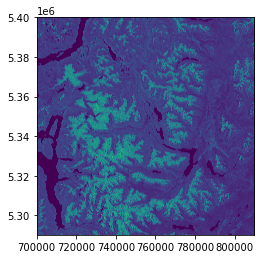

<AxesSubplot:>

In [9]:
band8 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B08_10m.jp2', driver='JP2OpenJPEG') 
band3 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B03_10m.jp2', driver='JP2OpenJPEG') 
band4 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B04_10m.jp2', driver='JP2OpenJPEG') 


#export false color image
falseColor = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/FalseColor_LagoPuelo.tiff', 'w', driver='Gtiff',
                          width=band2.width, height=band2.height,
                          count=3,
                          crs=band2.crs,
                          transform=band2.transform,
                          dtype='uint16'                   
                         )
falseColor.write(band3.read(1),3) #Blue
falseColor.write(band4.read(1),2) #Green
falseColor.write(band8.read(1),1) #Red
falseColor.close()

src2 = rasterio.open(r"C:/Proyecto_Final_Imagenes_Satelitales/FalseColor_LagoPuelo.tiff", count=3)
plot.show(src2)


### 3) NDVI Based on combination of bands (B8 - B4)/(B8 + B4)

Indice de vegetación de diferencia normalizada (NDVI)
El índice de vegetación de diferencia normalizada es un índice simple pero efectivo para cuantificar la vegetación verde. Es una medida del estado de salud de la vegetación basada en la forma en que las plantas reflejan la luz en ciertas longitudes de onda. El rango de valores del NDVI es de -1 a 1. Los valores negativos del NDVI (valores cercanos a -1) corresponden al agua. Los valores cercanos a cero (-0,1 a 0,1) corresponden generalmente a zonas áridas de roca, arena o nieve. Los valores bajos y positivos representan los arbustos y los pastizales (aproximadamente de 0,2 a 0,4), mientras que los valores altos indican los bosques húmedos templados y tropicales (valores próximos a 1).

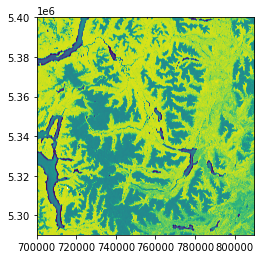

<AxesSubplot:>

In [10]:
import rasterio as rio
import os

import warnings
warnings.filterwarnings('ignore')

#setting the env variables 
os.environ['GDAL_DATA'] = os.environ['CONDA_PREFIX'] + r'\Library\share\gdal'

b4 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B04_10m.jp2')
meta = b4.meta
b4 = b4.read()
b8 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B08_10m.jp2') #nir
b8 = b8.read()

ndvi_LagoPuelo = (b8.astype(float) - b4.astype(float))/(b8 + b4)

meta.update(driver = 'GTiff')
meta.update(dtype = rio.float32)

#writing the band as a tiff image
with rio.open('C:/Proyecto_Final_Imagenes_Satelitales/ndvi_LagoPuelo.tiff', 'w', **meta) as dst:
    dst.write(ndvi_LagoPuelo.astype(rio.float32))    
    
src3 = rasterio.open(r"C:/Proyecto_Final_Imagenes_Satelitales/ndvi_LagoPuelo.tiff", count=3)
plot.show(src3)


### 4) False Color Urban composite (Based on bands 12,11,4)

Este compuesto se utiliza para visualizar más claramente las zonas urbanizadas. La vegetación es visible en tonos de verde, mientras que las zonas urbanizadas están representadas por el blanco, el gris o el púrpura. Los suelos, la arena y los minerales se muestran en una variedad de colores. La nieve y el hielo aparecen en azul oscuro, y el agua en negro o azul. Las áreas inundadas son de un azul muy oscuro y casi negras. El compuesto es útil para detectar incendios forestales y calderas de volcanes, ya que se muestran en tonos de rojo y amarillo.

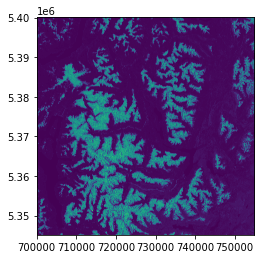

<AxesSubplot:>

In [11]:
band12 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B12_20m.jp2', driver='JP2OpenJPEG') 
band11 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B11_20m.jp2', driver='JP2OpenJPEG') 
band4 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B04_20m.jp2', driver='JP2OpenJPEG') 


#export false color Urban composite image
falseColor_urban_composite = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/FalseColor_urban_composite_LagoPuelo.tiff', 'w', driver='Gtiff',
                          width=band4.width, height=band4.height,
                          count=3,
                          crs=band2.crs,
                          transform=band2.transform,
                          dtype='uint16'                   
                         )
falseColor_urban_composite.write(band12.read(1),3) #Blue
falseColor_urban_composite.write(band11.read(1),2) #Green
falseColor_urban_composite.write(band4.read(1),1) #Red
falseColor_urban_composite.close()

src4 = rasterio.open(r"C:/Proyecto_Final_Imagenes_Satelitales/FalseColor_urban_composite_LagoPuelo.tiff", count=3)
plot.show(src4)


### 5) Normalized Difference Moisture Index (NDMI)

El índice de diferencia de humedad normalizada (NDMI) se utiliza para determinar el contenido de agua de la vegetación y vigilar las sequías. El rango de valores del NDMI es de -1 a 1. Los valores negativos del NDMI (valores cercanos a -1) corresponden a un suelo estéril. Los valores en torno a cero (-0,2 a 0,4) corresponden generalmente al estrés hídrico. Los valores altos y positivos representan una elevada cubierta sin estrés hídrico (aproximadamente 0,4 a 1).

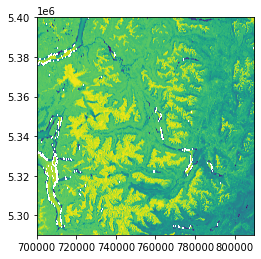

<AxesSubplot:>

In [12]:
import rasterio as rio
import os

import warnings
warnings.filterwarnings('ignore')

#setting the env variables 
os.environ['GDAL_DATA'] = os.environ['CONDA_PREFIX'] + r'\Library\share\gdal'

#============================Lago Puelo============================#

b8A = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B8A_20m.jp2')
meta = b8A.meta
b8A = b8A.read()
b11 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B11_20m.jp2')
b11 = b11.read()

ndwi_lmc = (b8A.astype(float) - b11.astype(float))/(b8A + b11)

meta.update(driver = 'GTiff')
meta.update(dtype = rio.float32)

#writing the band as a tiff image
with rio.open('C:/Proyecto_Final_Imagenes_Satelitales/ndmi_LagoPuelo.tiff', 'w', **meta) as dst:
    dst.write(ndwi_lmc.astype(rio.float32))
    
src5 = rasterio.open(r"C:/Proyecto_Final_Imagenes_Satelitales/ndmi_LagoPuelo.tiff", count=3)
plot.show(src5)

### 6) Short wave infrared composite (SWIR) (Based on bands 12,8A,4)

Las mediciones del infrarrojo de onda corta (SWIR) pueden ayudar a los científicos a estimar cuánta agua está presente en las plantas y el suelo, ya que el agua refleja las longitudes de onda SWIR. Las bandas de infrarrojos de onda corta (una banda es una región del espectro electromagnético; un sensor de satélite puede tomar imágenes de la Tierra en diferentes bandas) también son útiles para distinguir entre los tipos de nubes (nubes de agua frente a nubes de hielo), la nieve y el hielo, todos los cuales aparecen blancos en la luz visible. En este compuesto la vegetación aparece en tonos de rojo, los suelos varían de marrón oscuro a marrón claro y las zonas urbanas son de color azul cian. La tierra recién quemada se refleja fuertemente en las bandas de SWIR, lo que las hace valiosas para la cartografía de los daños causados por el fuego. Cada tipo de roca refleja la luz infrarroja de onda corta de forma diferente, lo que permite trazar un mapa geológico comparando la luz reflejada de la radiación solar.

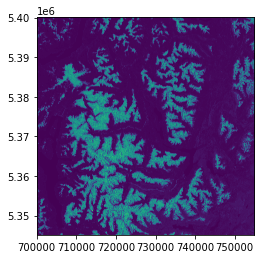

<AxesSubplot:>

In [13]:
band12 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B12_20m.jp2', driver='JP2OpenJPEG') 
band8A = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B8A_20m.jp2', driver='JP2OpenJPEG') 
band4 = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B04_20m.jp2', driver='JP2OpenJPEG') 


#export swir image
swir = rasterio.open('C:/Proyecto_Final_Imagenes_Satelitales/SWIR_LagoPuelo.tiff', 'w', driver='Gtiff',
                          width=band4.width, height=band4.height,
                          count=3,
                          crs=band2.crs,
                          transform=band2.transform,
                          dtype='uint16'                   
                         )
swir.write(band12.read(1),3) 
swir.write(band8A.read(1),2) 
swir.write(band4.read(1),1) 
swir.close()

src6 = rasterio.open(r"C:/Proyecto_Final_Imagenes_Satelitales/SWIR_LagoPuelo.tiff", count=3)
plot.show(src6)

### 7) NDWI (for water content) (Based on combination of bands (B3 - B8)/(B3 + B8))

Indice de Diferencia Normalizada del Agua (NDWI)
El índice diferencial normalizado de agua es el más apropiado para la cartografía de las masas de agua. Los valores de las masas de agua son mayores de 0,5. La vegetación tiene valores más pequeños. Las características construidas tienen valores positivos entre cero y 0,2.

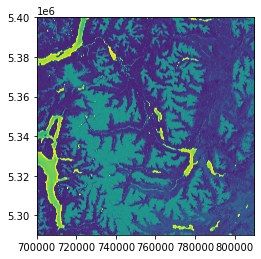

<AxesSubplot:>

In [14]:
import rasterio as rio
import os

import warnings
warnings.filterwarnings('ignore')

#setting the env variables 
os.environ['GDAL_DATA'] = os.environ['CONDA_PREFIX'] + r'\Library\share\gdal'

b3 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B03_10m.jp2')
meta = b3.meta
b3 = b3.read()
b8 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B08_10m.jp2') #nir
b8 = b8.read()

ndwi_wc_LagoPuelo = (b3.astype(float) - b8.astype(float))/(b3 + b8)

meta.update(driver = 'GTiff')
meta.update(dtype = rio.float32)

#writing the band as a tiff image
with rio.open('C:/Proyecto_Final_Imagenes_Satelitales/ndwi_wc_LagoPuelo.tiff', 'w', **meta) as dst:
    dst.write(ndwi_wc_LagoPuelo.astype(rio.float32)) 

src7 = rasterio.open(r"C:/Proyecto_Final_Imagenes_Satelitales/ndwi_wc_LagoPuelo.tiff", count=3)
plot.show(src7)


### 8) NDCI - Normalised Difference Chlorophyll Index
Normalised difference chlorophyll index (NDCI)
NDCI = (B5 - B4)/(B5 + B4)

Index for Chlorophyll-a concentration (Chl-a)
Chl-a (Second order derivative of NDCI) -> (Gilerson et al. for chla)

El Índice de Clorofila de Diferencia Normalizada muestra valores más brillantes para la clorofila alta
y valores más oscuros para un contenido más bajo

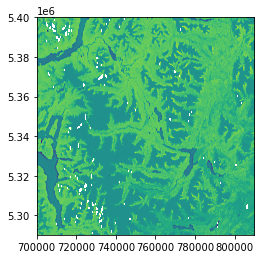

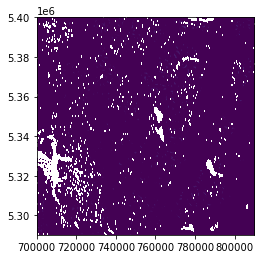

<AxesSubplot:>

In [15]:
import rasterio as rio
import os

import warnings
warnings.filterwarnings('ignore')

#setting the env variables 
os.environ['GDAL_DATA'] = os.environ['CONDA_PREFIX'] + r'\Library\share\gdal'

b5 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B05_20m.jp2')
meta = b5.meta
b5 = b5.read()
b4 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B04_20m.jp2')
b4 = b4.read()


b3 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B03_10m.jp2') 
b3 = b3.read()
b2 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R10m/T18GYU_20201106T142741_B02_10m.jp2') 
b2 = b2.read()

ndci_LagoPuelo = (b5.astype(float) - b4.astype(float))/(b5 + b4)



x = (35.75 * (b3.astype(float)/b2.astype(float)) -19.3) # Gilerson et al. for chla

chla_LagoPuelo = pow(x, 1.124)

meta.update(driver = 'GTiff')
meta.update(dtype = rio.float32)

#writing the band as a tiff image
with rio.open('C:/Proyecto_Final_Imagenes_Satelitales/ndci_LagoPuelo.tiff', 'w', **meta) as dst:
     dst.write(ndci_LagoPuelo.astype(rio.float32))

with rio.open('C:/Proyecto_Final_Imagenes_Satelitales/chla_LagoPuelo.tiff', 'w', **meta) as dst:
    dst.write(chla_LagoPuelo.astype(rio.float32))

src8 = rasterio.open(r"C:/Proyecto_Final_Imagenes_Satelitales/ndci_LagoPuelo.tiff", count=3)
plot.show(src8)

src9 = rasterio.open(r"C:/Proyecto_Final_Imagenes_Satelitales/chla_LagoPuelo.tiff", count=3)
plot.show(src9)

### 9) Normalised Difference Snow Index (NDSI) (Based on combination of bands (B3 - B11)/(B3 + B11))

El índice de diferencia de nieve normalizado Sentinel-2 puede utilizarse para diferenciar entre nubes y cubierta de nieve, ya que la nieve absorbe la luz infrarroja de onda corta, pero se refleja en el infrarrojo visible, mientras que la nube es generalmente reflectante en ambas longitudes de onda.

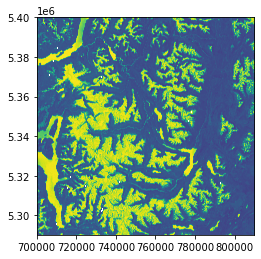

<AxesSubplot:>

In [16]:
import rasterio as rio
import os

import warnings
warnings.filterwarnings('ignore')

#setting the env variables 
os.environ['GDAL_DATA'] = os.environ['CONDA_PREFIX'] + r'\Library\share\gdal'

b3 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B03_20m.jp2')
meta = b3.meta
b3 = b3.read()
b11 = rio.open('C:/Proyecto_Final_Imagenes_Satelitales/R20m/T18GYU_20201106T142741_B11_20m.jp2')
b11 = b11.read()

ndsi_LagoPuelo = (b3.astype(float) - b11.astype(float))/(b3 + b11)

meta.update(driver = 'GTiff')
meta.update(dtype = rio.float32)

#writing the band as a tiff image
with rio.open('C:/Proyecto_Final_Imagenes_Satelitales/ndsi_LagoPuelo.tiff', 'w', **meta) as dst:
    dst.write(ndsi_LagoPuelo.astype(rio.float32))    
    
src10 = rio.open(r"C:/Proyecto_Final_Imagenes_Satelitales/ndsi_LagoPuelo.tiff", count=3)
plot.show(src10)
